In [2]:
# ====== Cell 1: Imports and Setup ======
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
# ====== Cell 2: Load MNIST Dataset ======
transform = transforms.Compose([
    transforms.ToTensor()  # converts to tensor and normalizes to [0,1]
])

mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_test  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Split training into train/validation
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(mnist_test, batch_size=128, shuffle=False)

print(f"Train: {len(train_dataset)}  Val: {len(val_dataset)}  Test: {len(mnist_test)}")


100%|██████████| 9.91M/9.91M [00:05<00:00, 1.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 272kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.72MB/s]

Train: 48000  Val: 12000  Test: 10000


In [4]:
# ====== Cell 3: Autoencoder Definition ======
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: 784 -> 256 -> 32
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )
        # Decoder: 32 -> 256 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)     # Flatten
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(x.size(0), 1, 28, 28)
        return out

model = Autoencoder().to(device)
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [5]:
# ====== Cell 4: Loss and Optimizer ======
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [6]:
# ====== Cell 5: Training Loop ======
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}")


Epoch 1/20: 100%|██████████| 375/375 [00:01<00:00, 316.34it/s]


Epoch [1/20] Train Loss: 0.045747  Val Loss: 0.022714


Epoch 2/20: 100%|██████████| 375/375 [00:01<00:00, 337.67it/s]


Epoch [2/20] Train Loss: 0.017736  Val Loss: 0.014366


Epoch 3/20: 100%|██████████| 375/375 [00:01<00:00, 343.12it/s]


Epoch [3/20] Train Loss: 0.012623  Val Loss: 0.011432


Epoch 4/20: 100%|██████████| 375/375 [00:01<00:00, 341.80it/s]


Epoch [4/20] Train Loss: 0.010542  Val Loss: 0.009989


Epoch 5/20: 100%|██████████| 375/375 [00:01<00:00, 334.77it/s]


Epoch [5/20] Train Loss: 0.009361  Val Loss: 0.009105


Epoch 6/20: 100%|██████████| 375/375 [00:01<00:00, 341.63it/s]


Epoch [6/20] Train Loss: 0.008621  Val Loss: 0.008515


Epoch 7/20: 100%|██████████| 375/375 [00:01<00:00, 340.90it/s]


Epoch [7/20] Train Loss: 0.008080  Val Loss: 0.008132


Epoch 8/20: 100%|██████████| 375/375 [00:01<00:00, 328.04it/s]


Epoch [8/20] Train Loss: 0.007647  Val Loss: 0.007678


Epoch 9/20: 100%|██████████| 375/375 [00:01<00:00, 337.90it/s]


Epoch [9/20] Train Loss: 0.007298  Val Loss: 0.007381


Epoch 10/20: 100%|██████████| 375/375 [00:01<00:00, 336.75it/s]


Epoch [10/20] Train Loss: 0.007016  Val Loss: 0.007143


Epoch 11/20: 100%|██████████| 375/375 [00:01<00:00, 342.76it/s]


Epoch [11/20] Train Loss: 0.006779  Val Loss: 0.006927


Epoch 12/20: 100%|██████████| 375/375 [00:01<00:00, 340.22it/s]


Epoch [12/20] Train Loss: 0.006586  Val Loss: 0.006749


Epoch 13/20: 100%|██████████| 375/375 [00:01<00:00, 341.24it/s]


Epoch [13/20] Train Loss: 0.006399  Val Loss: 0.006610


Epoch 14/20: 100%|██████████| 375/375 [00:01<00:00, 318.25it/s]


Epoch [14/20] Train Loss: 0.006249  Val Loss: 0.006477


Epoch 15/20: 100%|██████████| 375/375 [00:01<00:00, 337.09it/s]


Epoch [15/20] Train Loss: 0.006118  Val Loss: 0.006347


Epoch 16/20: 100%|██████████| 375/375 [00:01<00:00, 343.54it/s]


Epoch [16/20] Train Loss: 0.005993  Val Loss: 0.006235


Epoch 17/20: 100%|██████████| 375/375 [00:01<00:00, 343.52it/s]


Epoch [17/20] Train Loss: 0.005892  Val Loss: 0.006126


Epoch 18/20: 100%|██████████| 375/375 [00:01<00:00, 343.07it/s]


Epoch [18/20] Train Loss: 0.005801  Val Loss: 0.006066


Epoch 19/20: 100%|██████████| 375/375 [00:01<00:00, 343.55it/s]


Epoch [19/20] Train Loss: 0.005715  Val Loss: 0.006016


Epoch 20/20: 100%|██████████| 375/375 [00:01<00:00, 342.75it/s]


Epoch [20/20] Train Loss: 0.005638  Val Loss: 0.005942


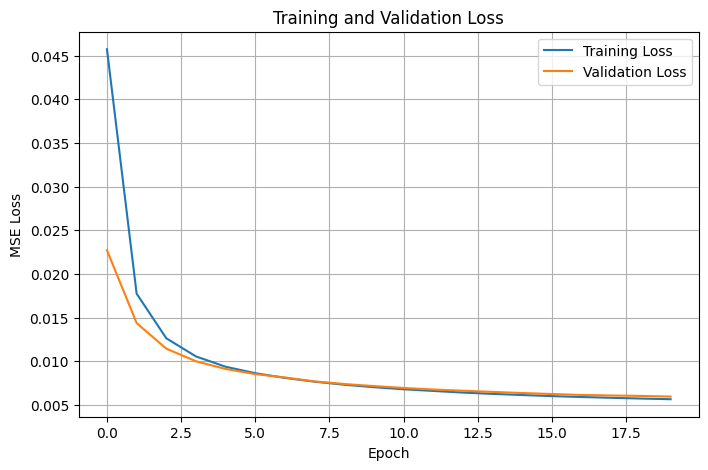

In [7]:
# ====== Cell 6: Plot Loss Curves ======
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


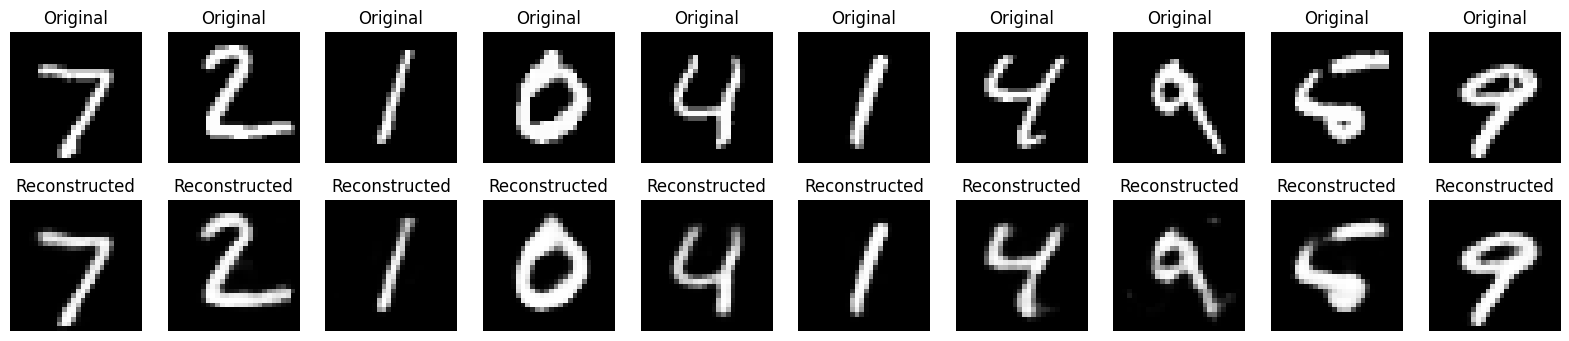

In [8]:
# ====== Cell 7: Show Original vs Reconstructed ======
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    reconstructions = model(images)

# Move to CPU for plotting
images = images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

n = 10  # number of examples to show
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()


In [9]:
# ====== Cell 8: Save Model ======
torch.save(model.state_dict(), "autoencoder_mnist.pth")
print("Model saved to autoencoder_mnist.pth")


Model saved to autoencoder_mnist.pth
